In [1]:
from dataloader import get_dataloaders
from utils import parse_args
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from datasets import load_dataset
import numpy as np

/home/metod/miniconda3/envs/msdnet2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found cached dataset parquet (/home/metod/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


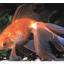

In [2]:
tiny_imagenet_val = load_dataset('Maysee/tiny-imagenet', split='valid')
tiny_imagenet_val[0]['image']

In [3]:
# compute normalization values for Tiny ImageNet
tiny_imagenet_train = load_dataset('Maysee/tiny-imagenet', split='train')
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # transforms images from [0,255] to [0,1] range
])

train_set = []
for i, x in enumerate(tiny_imagenet_train):
    if x['image'].mode != 'RGB':
        x['image'] = x['image'].convert('RGB')
    train_set.append(train_transform(x['image']))


# stack all images into a single tensor
train_set = torch.stack(train_set, dim=0)


# compute mean and std
mean = train_set.mean(dim=(0, 2, 3))
std = train_set.std(dim=(0, 2, 3))

print("mean: ", mean)
print("std: ", std)

Found cached dataset parquet (/home/metod/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


mean:  tensor([0.4832, 0.4440, 0.3909])
std:  tensor([0.2612, 0.2519, 0.2640])


In [4]:
tiny_imagenet_train = load_dataset('Maysee/tiny-imagenet', split='train')
tiny_imagenet_val = load_dataset('Maysee/tiny-imagenet', split='valid')

normalize = transforms.Normalize(
    mean=[0.4835, 0.4442, 0.3912], std=[0.2613, 0.2520, 0.2642]
)

# TODO: double check transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    # TransposeImage(),
    transforms.ToTensor(),
    normalize
])

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    # TransposeImage(),
    transforms.ToTensor(),
    normalize
])

train_set = []
for i, x in enumerate(tiny_imagenet_train):
    if x['image'].mode != 'RGB':
        x['image'] = x['image'].convert('RGB')
    train_set.append((train_transform(x['image']), x['label']))

val_set = []
for i, x in enumerate(tiny_imagenet_val):
    if x['image'].mode != 'RGB':
        x['image'] = x['image'].convert('RGB')
    val_set.append((val_transform(x['image']), x['label']))

Found cached dataset parquet (/home/metod/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/metod/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [6]:
train_loader = torch.utils.data.DataLoader(
                train_set,
                batch_size=32, shuffle=True,
                num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
                val_set,
                batch_size=32, shuffle=False,
                num_workers=4, pin_memory=True)

In [7]:
for x, y in val_loader:
    print(x.shape, y.shape)
    print(x[0])
    break

torch.Size([32, 3, 64, 64]) torch.Size([32])
tensor([[[1.8566, 1.8716, 1.9016,  ..., 1.9616, 1.9616, 1.9616],
         [1.9166, 1.9016, 1.9016,  ..., 1.9616, 1.9616, 1.9616],
         [1.9616, 1.9616, 1.9316,  ..., 1.9466, 1.9466, 1.9466],
         ...,
         [1.1212, 1.7215, 1.9767,  ..., 1.4814, 1.4664, 1.4064],
         [1.8266, 1.8566, 1.6015,  ..., 1.8866, 1.8266, 1.7515],
         [1.7816, 1.7215, 1.8266,  ..., 1.9616, 1.9316, 1.9316]],

        [[2.1744, 2.1900, 2.1900,  ..., 2.1900, 2.1900, 2.1900],
         [2.2056, 2.1900, 2.1900,  ..., 2.1900, 2.1900, 2.1900],
         [2.2056, 2.2056, 2.1900,  ..., 2.1744, 2.1744, 2.1744],
         ...,
         [1.3497, 1.9721, 2.2056,  ..., 1.6920, 1.6765, 1.6142],
         [2.2056, 2.2056, 1.9877,  ..., 2.1122, 2.0966, 2.0188],
         [2.2056, 2.2056, 2.2056,  ..., 2.1900, 2.2056, 2.2056]],

        [[2.2449, 2.2598, 2.2746,  ..., 2.2895, 2.2895, 2.2895],
         [2.2895, 2.2746, 2.2746,  ..., 2.2895, 2.2895, 2.2895],
         [2.3